# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)
!pip install tomotopy
!pip install little_mallet_wrapper

import tomotopy as tp
import little_mallet_wrapper

In [2]:
# Import various libraries for data analysis and visualization
import seaborn
import glob
from pathlib import Path
import pandas as pd

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
# Q2 (code)
#Set the file paths of the 2 Twitter datasets
sanders_file = "C:\\Users\\yd180\\Desktop\\Assignment3-AD\\sanders_tweets.csv"
trump_file = "C:\\Users\\yd180\\Desktop\\Assignment3-AD\\trump_tweets.csv"
# Load Sanders dataset
sanders_tweets = pd.read_csv(sanders_file)
# Load Trump dataset
trump_tweets = pd.read_csv(trump_file)

# Concatenate the two data sets and merge them into a new data set
combined_tweets = pd.concat([sanders_tweets, trump_tweets])

#Reset the index of the merged data set to ensure that the index of the data set is a continuous sequence of integers
combined_tweets.reset_index(drop=True, inplace=True)

# Display the first few rows of the merged dataset
combined_tweets


,Username,TweetId,Title,Content
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk..."
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia..."
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...
...,...,...,...,...
30366,@realDonaldTrump,1346912780700577792,@realDonaldTrump_1346912780700577792,I am asking for everyone at the U.S. Capitol ...
30367,@realDonaldTrump,1346928882595885058,@realDonaldTrump_1346928882595885058,https://t.co/Pm2PKV0Fp3
30368,@realDonaldTrump,1347334804052844550,@realDonaldTrump_1347334804052844550,https://t.co/csX07ZVWGe
30369,@realDonaldTrump,1347555316863553542,@realDonaldTrump_1347555316863553542,"The 75,000,000 great American Patriots who vo..."


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [43]:
import re 
import nltk
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))

#Initialize the list used to store data
training_data = []   # Store preprocessed text data
original_texts = []  # Store raw, unprocessed text data
titles = []          # Store the title of each tweet

# Define functions for preprocessing text
def preprocess_text(text, title):
    # Convert text to lowercase
    processed_text = text.lower()

    # Remove 'rt' and 'amp'
    # Because the topic displayed in the first training model had meaningless words like rt and amp, I added code to delete them.
    processed_text = re.sub(r'\b(rt|amp)\b', '', processed_text)
    
    # Remove numbers
    #Source:https://stackoverflow.com/questions/12851791/removing-numbers-from-string
    processed_text = re.sub(r'\d+', '', processed_text)
    
    # Remove punctuation
    #Source:https://www.geeksforgeeks.org/python-remove-punctuation-from-string/
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    
    # Remove stopwords
    tokens = processed_text.split()  #Split the processed text into words by spaces
    filtered_tokens = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(filtered_tokens) #Re-concatenate the words in the filtered word list into a string with spaces
    
    # Remove URLs, user mentions, and specific Twitter tags
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)
    
    # Append processed text, original text, and title to respective lists
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(title)
    

# Apply text processing function to each row in the dataframe
#Source:https://www.datacamp.com/tutorial/pandas-apply
#Originally I wanted to use the iterrows method, but found that the apply function is faster when dealing with large data sets.(https://towardsdatascience.com/efficiently-iterating-over-rows-in-a-pandas-dataframe-7dd5f9992c01)
combined_tweets.apply(lambda x: preprocess_text(x['Content'], x['Title']), axis=1)

training_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yd180\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['wealth increase past months billion elon musk billion jeff bezos billion walton family billion bill gates billion mark zuckerberg year increase us minimum wage must tax rich raise minimum wage least',
 'amidst massive income wealth inequality tens millions americans working starvation wages need raise minimum wage living wage least hour excuses need act',
 'resources skills techniques get rid poverty question whether nation dr martin luther king jr ',
 'surviving attempt life russian activist alexei navalny detained bravely returning russia today call release united states must stand fighting corruption working democracy around world',
 'presidentelect bidens covid rescue plan begin provide people muchneeded support direct payments minimum wage look forward working colleagues congress urgently provide bold relief working families ',
 'veterans affairs singlepayer program pays half much medicare exact drugs theres absolutely reason thisother greed congress must take pharmaceutical ind

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [44]:
# Q4 (code)

# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10
# Initialize the model
model = tp.LDAModel(k=num_topics)

#Split each preprocessed text into words and add those words to a model
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")

#Train the topic model for 10 iterations on the data
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.487529908922367
Iteration: 10	Log-likelihood: -9.085993832164032
Iteration: 20	Log-likelihood: -8.885094797769234
Iteration: 30	Log-likelihood: -8.785356023009806
Iteration: 40	Log-likelihood: -8.723216761738597
Iteration: 50	Log-likelihood: -8.683867646715376
Iteration: 60	Log-likelihood: -8.659861640052645
Iteration: 70	Log-likelihood: -8.632998409785877
Iteration: 80	Log-likelihood: -8.614103131544681
Iteration: 90	Log-likelihood: -8.597053924006515


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [46]:
# Q5a (code)
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    # Get the first few words of each topic and concatenate them into a string
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

must us war change trump climate people security energy social

✨Topic 1✨

health care people americans must right need million every country

✨Topic 2✨

court states supreme federal people united puerto us rico government

✨Topic 3✨

people country america american americans today must women every nation

✨Topic 4✨

biden president joe democrats impeachment party trump republican schiff pelosi

✨Topic 5✨

great thank today white house america pm president tonight honor

✨Topic 6✨

great vote total endorsement strong state military complete amendment job

✨Topic 7✨

tax border wall us big trade dollars billion china country

✨Topic 8✨

news fake media people great many would bad big even

✨Topic 9✨

trump people vote senate republicans democrats president house want dont

✨Topic 10✨

president united states whitehouse us great north korea trump china

✨Topic 11✨

people never would even dont want new like democrats time

✨Topic 12✨

trump president ne

# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?<font size=4>


<div style="background-color: #F5FFFA;">
•✨Topic 0✨
    
  This theme may involve issues such as war, climate change, and social security. The keywords "war" and "security" may refer to national security policies or military   actions, "climate" and "energy" may involve environmental protection and energy policies, and "social" may involve social policies or issues. Due to the mention of     Trump, these issues may be related to the policies or actions of the Trump administration.

•✨Topic 1✨

  This topic may involve healthcare related issues, especially regarding the healthcare rights and needs of the American people. The keywords "health care" and "right"   indicate a possible discussion about healthcare rights, while "need" and "must" emphasize the necessity of healthcare. The mention of "every country" may be a          comparison of healthcare policies or systems in different countries.

•✨Topic 2✨

   This topic may involve issues related to the US judicial system and the federal government. Keywords - "court", "prime", and "federal" refer to institutions that       involve courts and federal government, while "states" may refer to courts and state governments in various states. "Puerto Rico" refers to Puerto Rico, a self          governing territory of the United States, which may be discussing federal court rulings, legal issues, or legal and political issues related to Puerto Rico.

•✨Topic 3✨

   This theme may focus on the country and people of the United States, and may involve issues such as national identity, national spirit, and gender equality. The        keywords "people", "American", "Americans", "women", and "nation" refer to Americans and the United States, "today" may indicate the current moment or situation,       and "must" may indicate some actions that must or should be taken, implying attention and response to a current situation.
   
•✨Topic 4✨

   This topic may involve various aspects of American politics, including political figures, parties, political events, and the relationships between politicians.         Words closely related to American politics such as Biden, President, Democratic Party, Impeachment, Trump, Republican Party, Adam Schiff and Nancy Pelosi appear        among the keywords. It may involve competition between Democrats and Republicans, political events such as impeachment proceedings, and the involvement or influence    of political figures such as Adam Schiff and Nancy Pelosi. This topic may include discussion and analysis of the political situation in the United States,              controversies and relationships between politicians and political parties.

•✨Topic 5✨

  This topic may involve praise, gratitude, or respect for the United States and its government, and may be a discussion about government decisions, presidential         activities, or national events. Because the keywords involve: "great"，"thank"，"white house"，"honor".

•✨Topic 6✨

  This topic may involve discussions on elections, political power, and legal systems. The keyword "great" may point to positive attitudes and emotions, expressing       appreciation for certain events or actions. The use of "vote" and "endorsement" may involve the election process and the expression of support for political parties.   In addition, "state" and "amendment" may involve issues related to government and legal systems. Finally, "military" and "job" may involve issues such as national      defense and employment, expressing concern for national security and economic development.

•✨Topic 7✨

  This topic may involve topics such as fiscal policy, international trade, and diplomatic relations, and may discuss economic relations and policy measures between      the United States and other countries. The keyword "tax" may refer to tax policies and the management of fiscal revenue. "Border" and "wall" may involve discussions    on border security and immigration policies. In addition, "trade" and "dollars" may point to issues related to international trade and monetary policy. Especially,     "China" may point to discussions on US China relations and policies towards China.

•✨Topic 8✨

  This topic may involve media coverage, public opinion, and information dissemination, and may discuss issues such as news credibility, media criticism, and             information authenticity. The keywords "news" and "media" point to the news reporting and media industry. And "fake" may point to issues of false information and       fake news. In addition, "people" and "many" may point to public opinions and viewpoints.

•✨Topic 9✨

  This topic may relate to the American political system and electoral system, party politics. The “trump” in the keyword refers to President Trump and his policies or   activities. And "people" and "vote" may refer to voters and electoral voting. There are also keywords such as "senate" and "house", "republicans" and "democrats"       that may be talking about the political system, electoral system, etc. "Want" and "dont" may indicate voters' wishes and attitudes.

•✨Topic 10✨

  This topic may relate to the US president, government and foreign policy, possibly talking about President Trump/US, relations with other countries, especially with    North Korea and China. The keywords "president" and "united states" point to the US President and the US government. And "whitehouse" may refer to issues related to    the president and his office. In addition, "north korea" and "china" may point to the relationship between the United States and these two countries, which may         involve issues such as foreign policy, international relations, and geopolitics. "trump" may involve President Trump's actions in the political arena.

•✨Topic 11✨

 This theme may involve the attitudes and desires of the people, as well as opposition or dissatisfaction with the government, policies, or other aspects. Keywords      such as "never", "don", "even", "want", etc. may express people's negation or rejection of certain policies, behaviors, or developments. Democrats may point to the     Democratic Party and its policies or actions.

•✨Topic 12✨

  According to keywords such as "trump", "president", "new", "jobs", "great", "economy", "record", "america", etc., this topic may involve evaluation of President        Trump and his administration , a discussion of policies or actions regarding the economy, jobs, and developments in the United States.

•✨Topic 13✨

  According to the keywords "trump", "fbi", "collusion", "election", "hunt", "russia", "campaign", "mueller", "obama" this topic may relate to President Trump and his    Government-related investigations, accusations or controversies may involve Russian interference in the U.S. election, the relationship between the Trump campaign      and Russia, FBI investigations, and other issues. "mueller" may refer to the investigation led by special counsel Robert Mueller, and "obama" may refer to former       President Barack Obama's ties to the investigation or campaign.

•✨Topic 14✨

  According to the keywords "workers", "wage", "hour", "minimum", and "living", this topic may involve workers' rights, salary issues, minimum wage standards and other   issues, and may focus on workers' living standards, remuneration, minimum wage policy, etc.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [49]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5787307852009932 
Per Topic: [0.5045619696378708, 0.6391473770141601, 0.49976382255554197, 0.5500931888818741, 0.643731415271759, 0.5629162400960922, 0.7385800451040268, 0.5635217964649201, 0.5677557349205017, 0.4746821984648705, 0.5127339996397495, 0.49209200143814086, 0.4348688691854477, 0.7685287445783615, 0.7279843747615814]



### Because X1 needs to plot the average coherence for models with different number of topics, retraining is performed below.
### Coherence for 10 topics models

In [51]:
# Change the number of topics to 10 
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10
# Initialize the model
model = tp.LDAModel(k=num_topics)

#Split each preprocessed text into words and add those words to a model
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")

#Train the topic model for 10 iterations on the data
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
    

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence for 10 topics models: {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.294846510059502
Iteration: 10	Log-likelihood: -8.903924981648858
Iteration: 20	Log-likelihood: -8.743314872197818
Iteration: 30	Log-likelihood: -8.668492736596521
Iteration: 40	Log-likelihood: -8.621396998302917
Iteration: 50	Log-likelihood: -8.58624074556299
Iteration: 60	Log-likelihood: -8.560425255033808
Iteration: 70	Log-likelihood: -8.54018182648698
Iteration: 80	Log-likelihood: -8.526955360268357
Iteration: 90	Log-likelihood: -8.514952026072898
==== Coherence for 10 topics models: c_v ====
Average: 0.5558136505633593 
Per Topic: [0.5467851817607879, 0.7107505232095719, 0.6268298238515854, 0.47086830660700796, 0.5235358282923699, 0.4467207744717598, 0.45834184885025026, 0.505155399441719, 0.6997350007295609, 0.5694138184189796]



### Coherence for 20 topics models

In [62]:
# Change the number of topics to 20
num_topics = 20
# Numer of topic words to print out
num_topic_words = 10
# Initialize the model
model = tp.LDAModel(k=num_topics)

#Split each preprocessed text into words and add those words to a model
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")

#Train the topic model for 10 iterations on the data
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
    

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence for 20 topics models: {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.532809468779847
Iteration: 10	Log-likelihood: -9.088937568215881
Iteration: 20	Log-likelihood: -8.877575959762842
Iteration: 30	Log-likelihood: -8.768441884794477
Iteration: 40	Log-likelihood: -8.700435925506659
Iteration: 50	Log-likelihood: -8.653115276120138
Iteration: 60	Log-likelihood: -8.620539437556978
Iteration: 70	Log-likelihood: -8.592753930864909
Iteration: 80	Log-likelihood: -8.56928551715815
Iteration: 90	Log-likelihood: -8.552169830976183
==== Coherence for 20 topics models: c_v ====
Average: 0.603550103418529 
Per Topic: [0.712651988863945, 0.47226573079824447, 0.6814383685588836, 0.5072980925440789, 0.64001824259758, 0.5422890782356262, 0.6263055384159089, 0.5937380790710449, 0.6025854349136353, 0.5268984824419022, 0.6117469727993011, 0.6616685584187507, 0.5142610959708691, 0.7562916338443756, 0.5287004537880421, 0.5873334348201752, 0.5574477382004261, 0.6004321783781051, 0.6168702661991119, 0.7307606995105743]



### Coherence for 25 topics models

In [72]:
# Change the number of topics to 25
num_topics = 25
# Numer of topic words to print out
num_topic_words = 10
# Initialize the model
model = tp.LDAModel(k=num_topics)

#Split each preprocessed text into words and add those words to a model
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")

#Train the topic model for 10 iterations on the data
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
    

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence for 25 topics models: {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.610502672004445
Iteration: 10	Log-likelihood: -9.09705454713815
Iteration: 20	Log-likelihood: -8.893518608550993
Iteration: 30	Log-likelihood: -8.793835101601132
Iteration: 40	Log-likelihood: -8.725373676329363
Iteration: 50	Log-likelihood: -8.675285589941144
Iteration: 60	Log-likelihood: -8.63711561985831
Iteration: 70	Log-likelihood: -8.607321872158675
Iteration: 80	Log-likelihood: -8.58451571533482
Iteration: 90	Log-likelihood: -8.564507401706425
==== Coherence for 25 topics models: c_v ====
Average: 0.6127460839301347 
Per Topic: [0.6075011253356933, 0.6151564359664917, 0.5625067710876465, 0.6773593842983245, 0.700119998306036, 0.5426088720560074, 0.5703922111541033, 0.556555762887001, 0.7146639078855515, 0.45734275579452516, 0.6417700454592705, 0.6467089340090751, 0.5936445742845535, 0.5652740448713303, 0.5873772710561752, 0.5244948551058769, 0.48709912598133087, 0.7537172019481659, 0.5924044996500015, 0.6307943813502789, 0

### Coherence for 30 topics models

In [66]:
# Change the number of topics to 30
num_topics = 30
# Numer of topic words to print out
num_topic_words = 10
# Initialize the model
model = tp.LDAModel(k=num_topics)

#Split each preprocessed text into words and add those words to a model
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")

#Train the topic model for 10 iterations on the data
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
    

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence for 30 topics models: {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.646186065012483
Iteration: 10	Log-likelihood: -9.15784782699973
Iteration: 20	Log-likelihood: -8.961633801858687
Iteration: 30	Log-likelihood: -8.840980997290536
Iteration: 40	Log-likelihood: -8.753527537656705
Iteration: 50	Log-likelihood: -8.697254538898392
Iteration: 60	Log-likelihood: -8.649203337674333
Iteration: 70	Log-likelihood: -8.616635867873761
Iteration: 80	Log-likelihood: -8.590768694600944
Iteration: 90	Log-likelihood: -8.571809246856734
==== Coherence for 30 topics models: c_v ====
Average: 0.6499858159571886 
Per Topic: [0.5875369295477867, 0.6995002061128617, 0.8500929713249207, 0.6049654424190521, 0.6086698994040489, 0.5330419681966305, 0.6369795471429824, 0.727399280667305, 0.6319764912128448, 0.590352649986744, 0.625798586010933, 0.5893921792507172, 0.6519870728254318, 0.640402689576149, 0.6968841433525086, 0.5594834119081498, 0.6889029562473297, 0.6352036476135254, 0.7623947262763977, 0.6620050325989724, 0.6

### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

## Q6 (words)

<div style="background-color: #F5FFFA;">

①The number of topics I initially used to train the model was 15, and the resulting coherence score was 0.5787. The consistency score of each topic ranges from 0.43 to 0.76. There are differences in the consistency performance of each topic, but overall it is consistent.

②I then adjusted the number of topics to 10 and the average consistency score was 0.5558. Compared with the initial model (topic number=15), there is a slight decrease, which means that after the number of topics is reduced, the coherence between topics is slightly reduced.

③After increasing the number of topics to 20, the average consistency score increased to 0.60355, which is slightly higher than the initial model, and the consistency of the model has improved.

④After increasing the number of topics again to 25, the average consistency score increased to 0.6127, which is slightly higher than the initial model, and the consistency of the model has improved. But compared with the number of 20 topics, the consistency score has not significantly improved. This may be that the model has reached a certain saturation point, which may increase the complexity of the model.

⑤When the number of topics further increased to 30, the average coherence score reached 0.6499, and the coherence score improved slightly, but it was still not significant enough.

Overall, based on the above data and analysis, as the number of topics increases, the coherence score of the model will also increase, and the coherence of the topic model will continue to improve. And increasing the number of themes to a certain level does not necessarily significantly enhance coherence. The model with 20 themes seems to strike a good balance between consistency and complexity, as it achieves relatively high consistency scores without making the model overly complex. So when determining the most suitable number of topics, it is crucial to balance consistency and model complexity.


### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

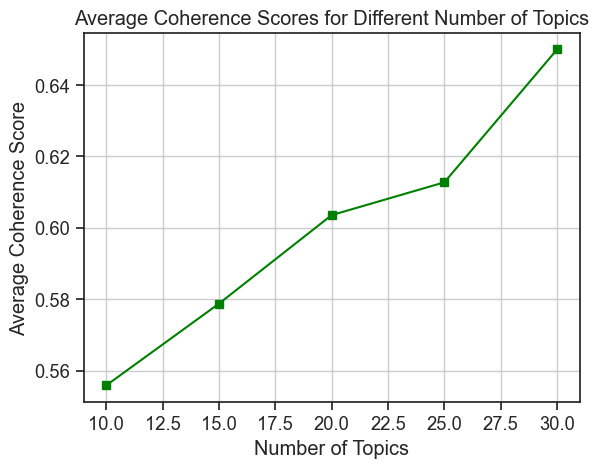

In [83]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model

import matplotlib.pyplot as plt

def plot_coherence_scores(coherence_data):
    # Extract coherence data for different number of topics
    num_topics = [10, 15, 20, 25, 30]
    coherence_scores = [data['Average'] for data in coherence_data]
    
    # Plotting
    plt.plot(num_topics, coherence_scores, marker='s',color='green')  #Set data points as squares
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence Score')
    plt.title('Average Coherence Scores for Different Number of Topics')
    plt.grid(True)  #Add gridlines
    plt.show()

# Use the consistency data for different subject numbers already available above
coherence_data = [
    {'Number of Topics': 10, 'Average': 0.5558136505633593},
    {'Number of Topics': 15, 'Average': 0.5787307852009932},
    {'Number of Topics': 20, 'Average': 0.603550103418529},
    {'Number of Topics': 25, 'Average': 0.6127460839301347},
    {'Number of Topics': 30, 'Average': 0.6499858159571886}
]

# Plot coherence scores
plot_coherence_scores(coherence_data)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [84]:
# Q7a (code)

# Still use the trained model with a topic number of 15
# Get the topic distribution of each tweet
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [108]:
from IPython.display import Markdown, display
import re

# Display the incoming string in Markdown format in Jupyter Notebook.
def make_md(string):
    display(Markdown(str(string)))
    
# Get the top documents for selected topics
def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc:
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')


    return

### Choose a topic that better represents Trump based on the previously trained model

In [122]:
#Based on the analysis of Q5b, select topic 10
get_top_docs(titles,topic_distributions, topic_index=10, n=8)

### ✨Topic 10✨

president united states whitehouse us great north korea trump china



---


✨  
**Topic Probability**: 0.9491097927093506  
**Document**: @realDonaldTrump_1208155412962447360



✨  
**Topic Probability**: 0.9478077292442322  
**Document**: @realDonaldTrump_1273034110353707008



✨  
**Topic Probability**: 0.9476640224456787  
**Document**: @realDonaldTrump_1210747615244996609



✨  
**Topic Probability**: 0.9448137283325195  
**Document**: @realDonaldTrump_1208587674342301703



✨  
**Topic Probability**: 0.9437934160232544  
**Document**: @realDonaldTrump_1208247467818594305



✨  
**Topic Probability**: 0.9393044710159302  
**Document**: @realDonaldTrump_1317175747254038530



✨  
**Topic Probability**: 0.929443359375  
**Document**: @realDonaldTrump_1208220823137505280



✨  
**Topic Probability**: 0.8872031569480896  
**Document**: SenSanders_1106306509825282048



### Choose a topic that better represents Sanders based on the previously trained model

In [130]:
#Based on the analysis of Q5b, select topic 3
get_top_docs(titles,topic_distributions, topic_index=3, n=8)

### ✨Topic 3✨

people country america american americans today must women every nation



---


✨  
**Topic Probability**: 0.9358848333358765  
**Document**: SenSanders_1336706675269652480



✨  
**Topic Probability**: 0.9172506332397461  
**Document**: SenSanders_986430246722392064



✨  
**Topic Probability**: 0.9172506332397461  
**Document**: SenSanders_1094303164805799936



✨  
**Topic Probability**: 0.9097569584846497  
**Document**: SenSanders_1090989073009967104



✨  
**Topic Probability**: 0.9037150740623474  
**Document**: SenSanders_1052267310290018304



✨  
**Topic Probability**: 0.9037150740623474  
**Document**: SenSanders_1031544892135297024



✨  
**Topic Probability**: 0.9007708430290222  
**Document**: SenSanders_938093095585017856



✨  
**Topic Probability**: 0.9007708430290222  
**Document**: SenSanders_1106291817186762752



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

# Q7b (words)

<div style="background-color: #F5FFFA;">
    
Topic 10:

As mentioned in the analysis of Q5b, this topic is related to foreign policy and relations between Trump and his government, North Korea, and China. According to the Topic Probability, Trump's tweets have high thematic relevance. This topic involves key issues frequently mentioned by Trump, such as presidential responsibilities, US national interests, White House policies, and international relations. Consistent with reality, it to some extent reflects Trump's political stance, policy priorities, reactions to domestic and international events, as well as his political goals and vision. Therefore, the tweets in Topic 10 are more representative of Trump

Topic 3:

It has been analyzed before that this topic may focus on the country and people of the United States, involving issues such as national identity, national spirit, and gender equality. Judging from Topic Probability, the top 8 most relevant tweets on this topic were all sent or forwarded by Sanders. This is consistent with Sanders’ consistent political stance and propositions. As a progressive politician, Sanders has always been concerned about social justice, people's rights, economic equality and other issues. This highlights that Topic 3 is more representative of Sanders.



## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [131]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

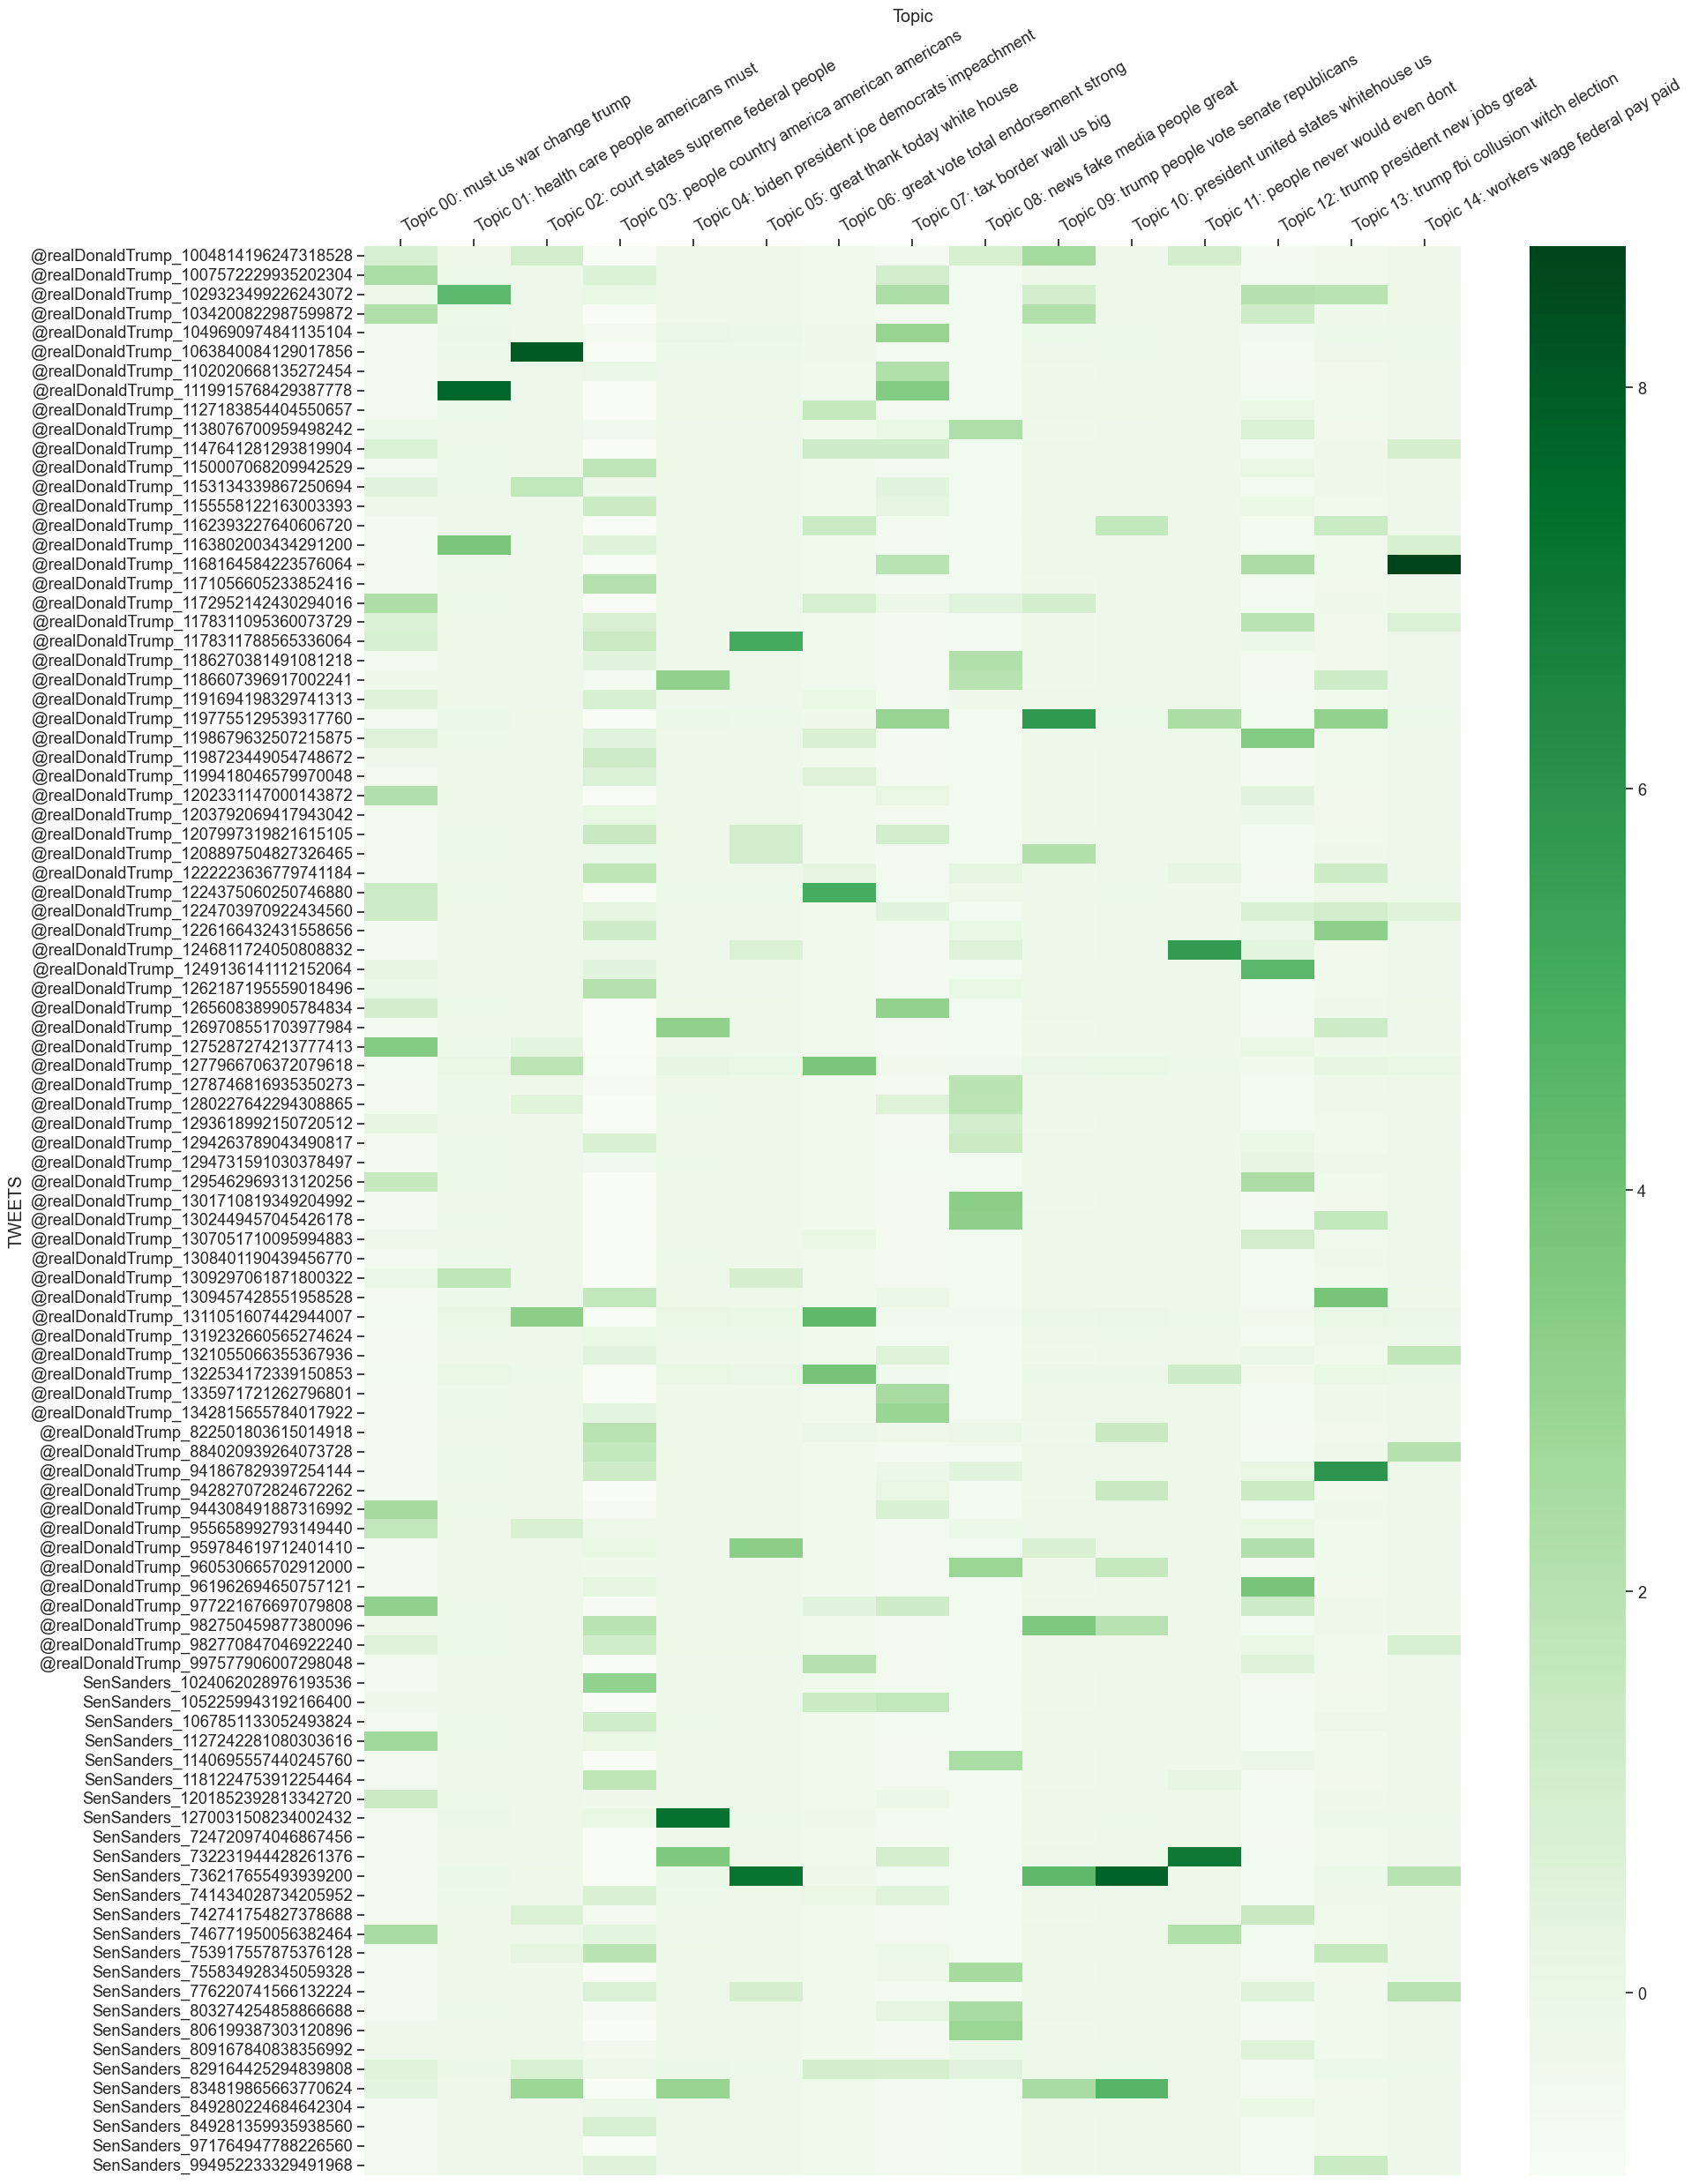

In [153]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)

# Define a function to generate the heatmap
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    #Combine labels and distributions into a dictionary list
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution[:len(topic_keys)]):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'TWEETS': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Establish a data frame and format the data, standardize the columns
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='TWEETS',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
    
    #Draw the final heat map
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()
    
# Call function to generate heat map    
plot_categories_by_topics_heatmap(target_labels,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Greens',
                                 dim=(20,25))


### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

## Q9 (words)

<div style="background-color: #F5FFFA;">

Looking at the graph the heat map doesn't show the distribution of Trump's and Sanders' topics with absolute clarity. This is because by itself there is a not insignificant difference in the number      of Trump's tweets and Sanders' tweets in the dataset. Secondly I find that Trump's tweets have a high degree of variability - his tweets may be quite rich and varied to some extent in terms of           topics, content or rhetoric, and may not be as focused on particular topics or themes. But the graph still shows that Trump is more inclined to some topics of political policy (immigration, taxes,       etc.),  campaigning, economy and trade, international affairs, etc. Sanders, on the other hand, is more likely to favor topics related to social justice, healthcare, education, and                       climate/environmental protection.n)

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

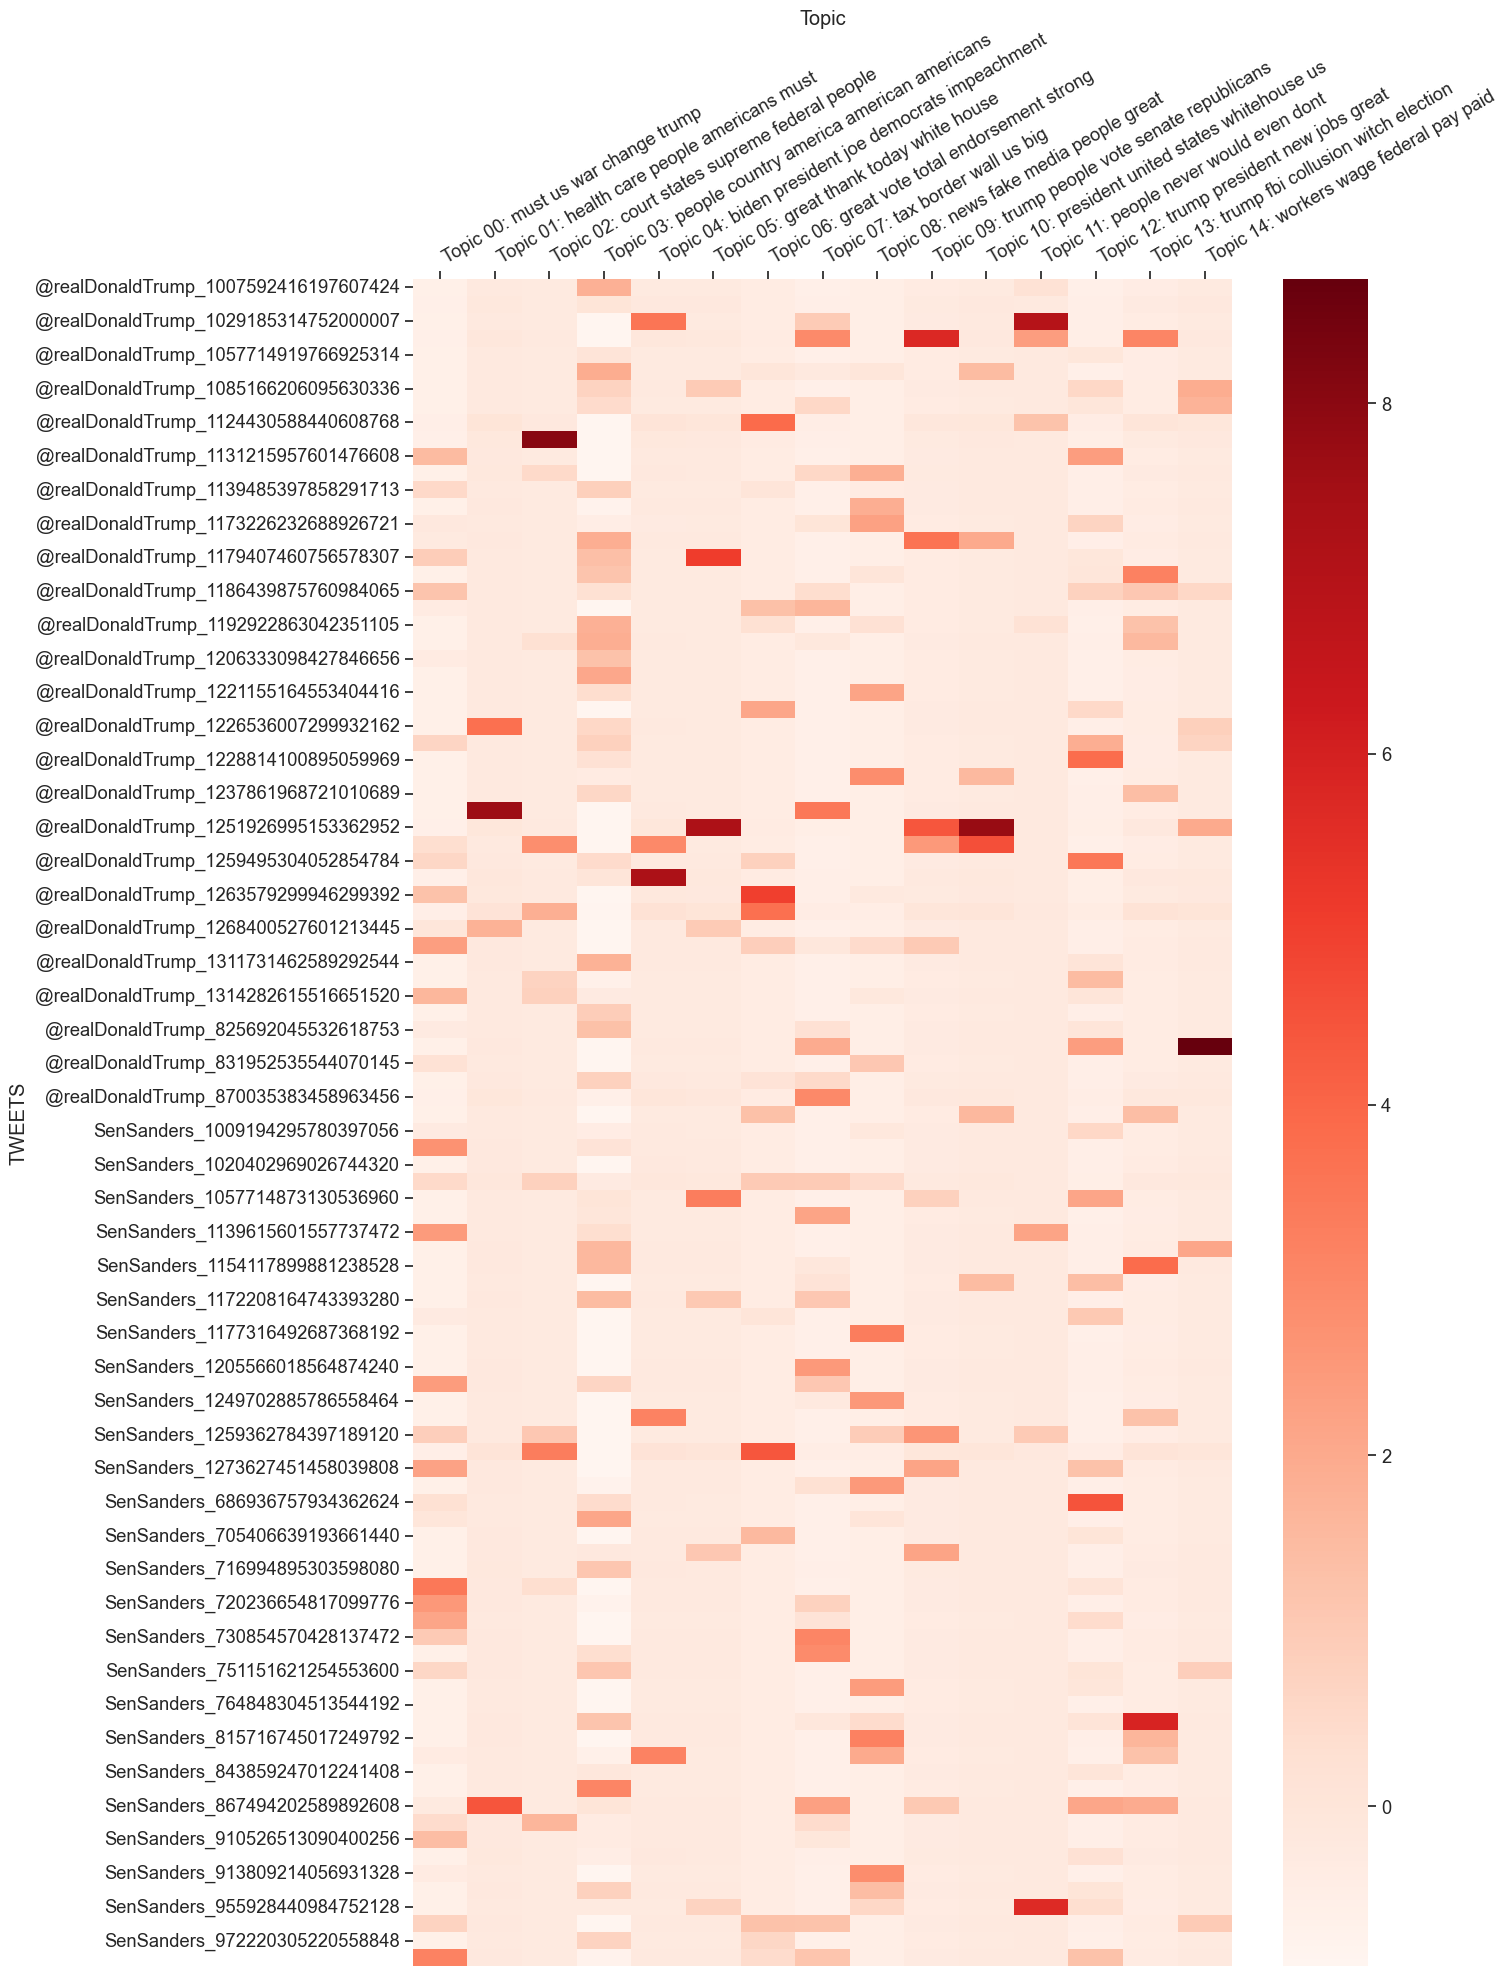

In [163]:
# X2 (code)
# Separate the tweet data of two people
Trump_Tweets = [title for title in titles if 'Trump' in title]
Sanders_Tweets = [title for title in titles if 'Sanders' in title]

##Due to the overall large amount of data in tweets, random sampling was chosen to avoid sample bias caused by temporal order and ensure the objectivity and representativeness of the samples.
# Sample 50 tweets from each candidate's tweets
Trump_sample = sample(Trump_Tweets, 50)
Sanders_sample = sample(Sanders_Tweets, 50)

# Combine two new samples together
balanced_sample = Trump_sample + Sanders_sample

# Draw a heat map
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=balanced_sample,
                                  color_map='Reds',
                                  dim=(15, 20))

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)
